# Multivariate GARCH in Tensorflow/Keras
# Not investment advice - use at you own risk.

Conditional volatility and correlation using multivariate GARCH on DAX and S&P500. Implementation with Tensorflow/Keras.  


Still under development - corresponding blogpost coming soon.

In [1]:
import pandas as np
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import timedelta
import pandas as pd

In [2]:
data = yf.download("^GDAXI ^GSPC", period="5y", interval="1d")

[*********************100%***********************]  2 of 2 completed


In [3]:
close = data["Close"]
returns = np.log(close).diff().dropna()

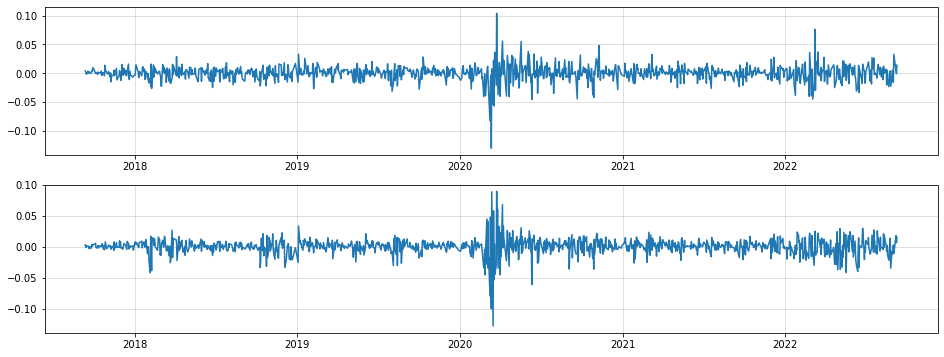

In [4]:
fig, axs = plt.subplots(2,1, figsize = (16,3*2))

for i in range(2):
    axs[i].plot(returns.iloc[:,i])
    axs[i].grid(alpha=0.5)


In [5]:
class MGARCH_DCC(tf.keras.Model):
    """
    Tensorflow/Keras implementation of multivariate GARCH under dynamic conditional correlation (DCC) specification.
    Further reading:
        - Engle, Robert. "Dynamic conditional correlation: A simple class of multivariate generalized autoregressive conditional heteroskedasticity models."
        - Bollerslev, Tim. "Modeling the Coherence in Short-Run Nominal Exchange Rates: A Multi-variate Generalized ARCH Model."
        - Lütkepohl, Helmut. "New introduction to multiple time series analysis."
    """
    
    def __init__(self, y):
        """
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        super().__init__()
        n_dims = y.shape[1]
        self.n_dims = n_dims
        
        self.MU = tf.Variable(np.mean(y,0)) #use a mean variable
        
        self.sigma0 = tf.Variable(np.std(y,0)) #initial standard deviations at t=0
        
        #we initialize all restricted parameters to lie inside the desired range
        #by keeping the learning rate low, this should result in admissible results
        #for more complex models, this might not suffice
        self.alpha0 = tf.Variable(np.std(y,0))
        self.alpha = tf.Variable(tf.zeros(shape=(n_dims,))+0.25)
        self.beta = tf.Variable(tf.zeros(shape=(n_dims,))+0.25)
        
        self.L0 = tf.Variable(np.float32(np.linalg.cholesky(np.corrcoef(y.T)))) #decomposition of A_0
        self.A = tf.Variable(tf.zeros(shape=(1,))+0.9)
        self.B = tf.Variable(tf.zeros(shape=(1,))+0.05)
        
           
    def call(self, y):
        """
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        return self.get_conditional_dists(y)
    
    
    def get_log_probs(self, y):
        """
        Calculate log probabilities for a given matrix of time-series observations
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        return self.get_conditional_dists(y).log_prob(y)
    
        
    @tf.function
    def get_conditional_dists(self, y):
        """
        Calculate conditional distributions for given observations
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        T = tf.shape(y)[0]
        
        #create containers for looping
        mus = tf.TensorArray(tf.float32, size = T) #observation mean container
        Sigmas = tf.TensorArray(tf.float32, size = T) #observation covariance container

        
        sigmas = tf.TensorArray(tf.float32, size = T+1)
        us = tf.TensorArray(tf.float32, size = T+1)
        Qs = tf.TensorArray(tf.float32, size = T+1)
        
        
        #initialize respective values for t=0
        sigmas = sigmas.write(0, self.sigma0)
        A0 = tf.transpose(self.L0)@self.L0
        Qs = Qs.write(0, A0) #set initial unnormalized correlation equal to mean matrix
        us = us.write(0, tf.zeros(shape=(self.n_dims,))) #initial observations equal to zero
        
        
        #convenience
        sigma0 = self.sigma0
        alpha0 = self.alpha0**2 #ensure positivity
        alpha = self.alpha
        beta = self.beta

        A = self.A
        B = self.B
        
        
        for t in tf.range(T):
            #tm1 = 't minus 1'
            #suppress conditioning on past in notation
            
            #1) calculate conditional standard deviations
            u_tm1 = us.read(t) 
            sigma_tm1 = sigmas.read(t)
            
            sigma_t = (alpha0 + alpha*sigma_tm1**2 + beta*u_tm1**2)**0.5
            
            #2) calculate conditional correlations
            u_tm1_standardized = u_tm1/sigma_tm1
                   
            Psi_tilde_tm1 = tf.reshape(u_tm1_standardized, (self.n_dims,1))@tf.reshape(u_tm1_standardized, (1,self.n_dims))

            Q_tm1 = Qs.read(t)
            Q_t = A0 + A*(Q_tm1 - A0) + B*(Psi_tilde_tm1 - A0)
            R_t = self.cov_to_corr(Q_t)
            
            #3) calculate conditional covariance
            D_t = tf.linalg.LinearOperatorDiag(sigma_t)
            Sigma_t = D_t@R_t@D_t
              
            
            #4) store values for next iteration
            sigmas = sigmas.write(t+1, sigma_t)
            us = us.write(t+1, y[t,:]-self.MU) #we want to model the zero-mean disturbances
            Qs = Qs.write(t+1, Q_t)
            
            mus = mus.write(t, self.MU)
            Sigmas = Sigmas.write(t, Sigma_t)
            
        return tfp.distributions.MultivariateNormalFullCovariance(mus.stack(), Sigmas.stack())
    
    
    def cov_to_corr(self, S):
        """
        Transforms covariance matrix to a correlation matrix via matrix operations
        Args:
            S: Symmetric, positive semidefinite covariance matrix (tf.Tensor)
        """
        D = tf.linalg.LinearOperatorDiag(1/(tf.linalg.diag_part(S)**0.5))
        return D@S@D
        
    

    def train_step(self, data):
        """
        Custom training step to handle keras model.fit given that there is no input-output structure in our model
        Args:
            S: Symmetric, positive semidefinite covariance matrix (tf.Tensor)
        """
        x,y = data
        with tf.GradientTape() as tape:
            loss = -tf.math.reduce_mean(self.get_log_probs(y))
            
        trainable_vars = self.trainable_weights
        gradients = tape.gradient(loss, trainable_vars)
        
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        return {"Current loss": loss}
    
    
    
    def sample_forecast(self, y, T_forecast = 30, n_samples=500):
        """
        Create forecast samples to use for monte-carlo simulation of quantities of interest about the forecast (e.g. mean, var, corr, etc.)
        WARNING: This is not optimized very much and can take some time to run, probably due to Python's slow loops - can likely be improved
        Args:
            y: numpy.array of training data, used to initialize the forecast values
            T_forecast: number of periods to predict (integer)
            n_samples: Number of samples to draw (integer)
        """
        T = tf.shape(y)[0]
        
        #create lists for looping; no gradients, thus no tf.TensorArrays needed
        #can initialize directly
        mus = []
        Sigmas = []

        us = [tf.zeros(shape=(self.n_dims,))]
        sigmas = [self.sigma0]        
        Qs = []
        
        #initialize remaining values for t=0
        A0 = tf.transpose(self.L0)@self.L0
        Qs.append(A0)
        
        
        #convenience
        sigma0 = self.sigma0 
        alpha0 = self.alpha0**2 #ensure positivity
        alpha = self.alpha
        beta = self.beta

        A = self.A
        B = self.B
        
        #'warmup' to initialize latest lagged features
        for t in range(T):
            #tm1 = 't minus 1'
            #suppress conditioning on past in notation
            u_tm1 = us[-1]
            sigma_tm1 = sigmas[-1]
            
            sigma_t = (alpha0 + alpha*sigma_tm1**2 + beta*u_tm1**2)**0.5
            
            u_tm1_standardized = u_tm1/sigma_tm1
            
            Psi_tilde_tm1 = tf.reshape(u_tm1_standardized, (self.n_dims,1))@tf.reshape(u_tm1_standardized, (1,self.n_dims))

            Q_tm1 = Qs[-1]
            Q_t = A0 + A*(Q_tm1 - A0) + B*(Psi_tilde_tm1 - A0)
            R_t = self.cov_to_corr(Q_t)
            
            D_t = tf.linalg.LinearOperatorDiag(sigma_t)
            Sigma_t = D_t@R_t@D_t
              
            
            sigmas.append(sigma_t)
            us.append(y[t,:]-self.MU) #we want to model the zero-mean disturbances
            Qs.append(Q_t)
            
            mus.append(self.MU)
            Sigmas.append(Sigma_t)
  
            
        #sample containers
        y_samples = []
        R_samples = []
        sigma_samples = []
        
        
        for n in range(n_samples):
            
            mus_samp = []
            Sigmas_samp = []

            sigmas_samp = [sigmas[-1]]
            us_samp = [us[-1]]
            Qs_samp = [Qs[-1]]
            
            #forecast containers
            ys_samp = []
            sig_samp = []
            R_samp = [] 
            
            
            for t in range(T_forecast):
                u_tm1 = us_samp[-1]
                sigma_tm1 = sigmas_samp[-1]

                sigma_t = (alpha0 + alpha**2 + beta*u_tm1**2)**0.5

                u_tm1_standardized = u_tm1/sigma_tm1
                
                Psi_tilde_tm1 = tf.reshape(u_tm1_standardized, (self.n_dims,1))@tf.reshape(u_tm1_standardized, (1,self.n_dims))

                Q_tm1 = Qs_samp[-1]
                Q_t = A0 + A*(Q_tm1 - A0) + B*(Psi_tilde_tm1 - A0)
                R_t = self.cov_to_corr(Q_t)

                D_t = tf.linalg.LinearOperatorDiag(sigma_t)
                Sigma_t = D_t@R_t@D_t


                sigmas_samp.append(sigma_t)
                Qs_samp.append(Q_t)
                
                ynext = tfp.distributions.MultivariateNormalFullCovariance(self.MU, Sigma_t).sample()
                ys_samp.append(tf.reshape(ynext,(1,1,-1)))
                sig_samp.append(tf.reshape(sigma_t,(1,1,-1)))
                R_samp.append(tf.reshape(R_t,(1,1,self.n_dims,self.n_dims)))
                
                us_samp.append(ynext-self.MU)
                
            y_samples.append(tf.concat(ys_samp,1))
            R_samples.append(tf.concat(R_samp,1))
            sigma_samples.append(tf.concat(sig_samp,1))
        
        return tf.concat(y_samples,0).numpy(), tf.concat(R_samples,0).numpy(), tf.concat(sigma_samples,0).numpy()

In [6]:
train = np.float32(returns)[:-90,:]
test = np.float32(returns)[-90:,:]

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


<Figure size 1152x432 with 0 Axes>

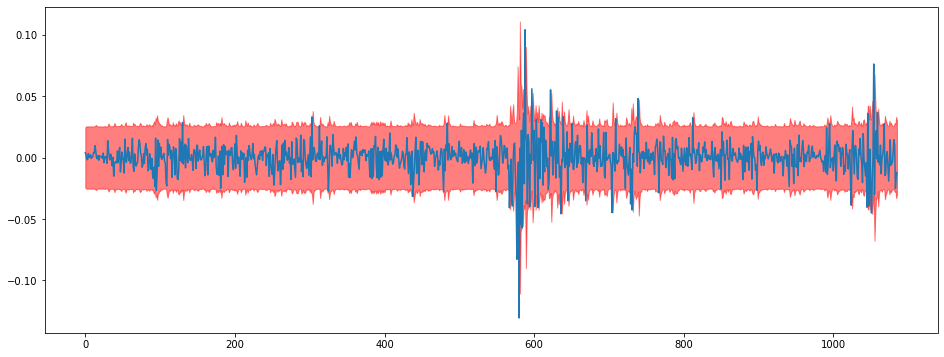

In [7]:
model = MGARCH_DCC(train)


from scipy.stats import norm
out = model(train)

means = out.mean().numpy()
stds = out.stddev().numpy()

lowers = norm(means, stds).ppf(0.05)
uppers = norm(means, stds).ppf(0.95)

plt.figure(figsize = (16,6))

i = 0

plt.figure(figsize = (16,6))
plt.plot(train[:,i])
plt.fill_between(np.arange(len(train)),lowers[:,i],uppers[:,i],color="red",alpha=0.5)

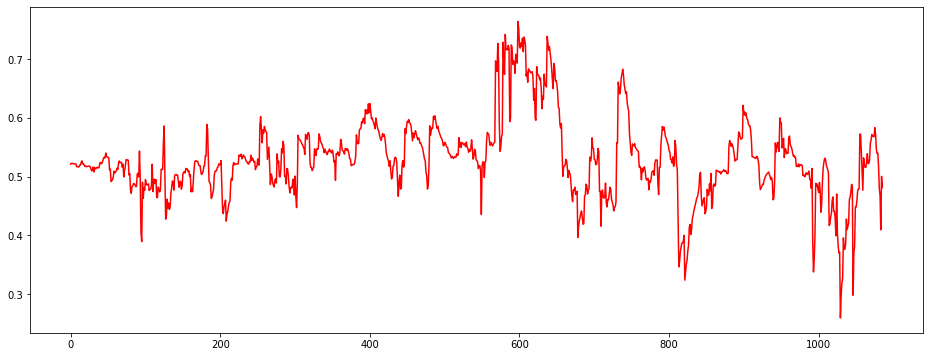

In [8]:
plt.figure(figsize = (16,6))

corr12 = [model.cov_to_corr(out.covariance()[i,:,:])[0,1].numpy() for i in range(len(train))]
plt.plot(corr12,c="red")

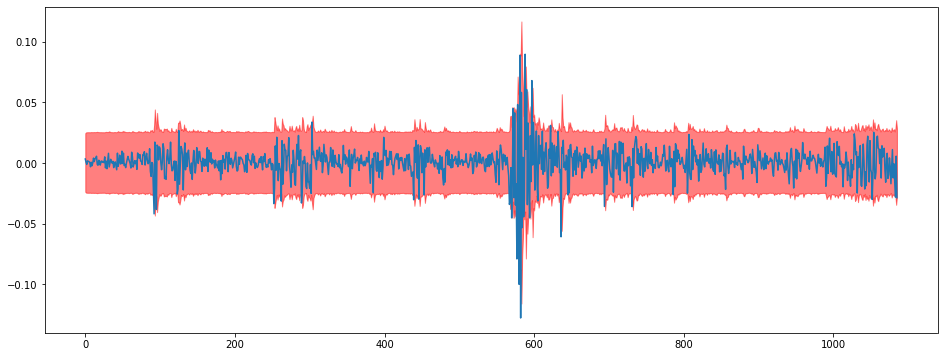

In [9]:
i = 1

plt.figure(figsize = (16,6))
plt.plot(train[:,i])
plt.fill_between(np.arange(len(train)),lowers[:,i],uppers[:,i],color="red",alpha=0.5)

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))

In [11]:
model.fit(train,train,batch_size=len(train), shuffle=False, epochs = 300, verbose=False)

In [12]:
out = model(train)

means = out.mean().numpy()
stds = out.stddev().numpy()

lowers = norm(means, stds).ppf(0.05)
uppers = norm(means, stds).ppf(0.95)


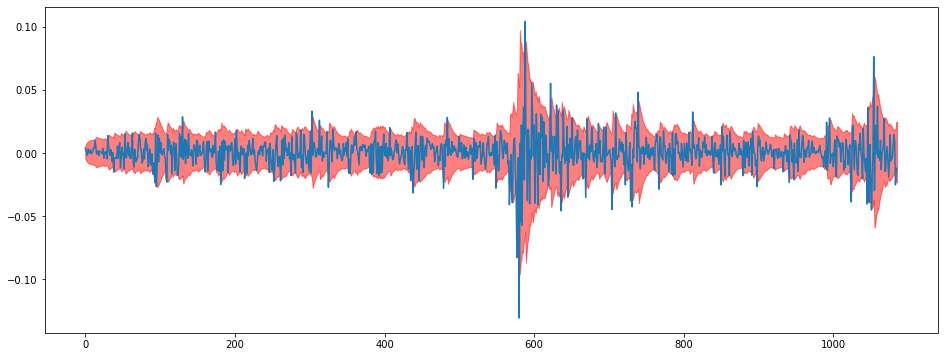

In [13]:
i = 0

plt.figure(figsize = (16,6))
plt.plot(train[:,i])
plt.fill_between(np.arange(len(train)),lowers[:,i],uppers[:,i],color="red",alpha=0.5)

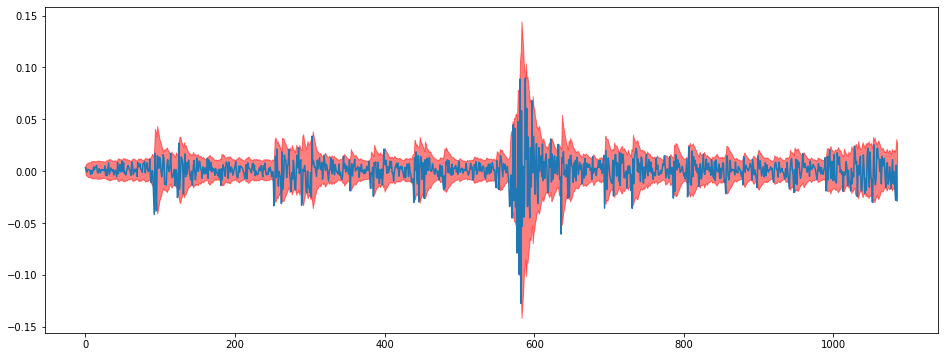

In [14]:
i = 1

plt.figure(figsize = (16,6))
plt.plot(train[:,i])
plt.fill_between(np.arange(len(train)),lowers[:,i],uppers[:,i],color="red",alpha=0.5)

In [15]:
corr12 = [model.cov_to_corr(out.covariance()[i,:,:])[0,1].numpy() for i in range(len(train))]


In [16]:
np.random.seed(123)
tf.random.set_seed(123)

fcast = model.sample_forecast(train,90,1000)


In [ ]:
out = model(np.float32(returns.values))

corr12 = [model.cov_to_corr(out.covariance()[i,:,:])[0,1].numpy() for i in range(len(returns))]


In [ ]:
corrs = fcast[1][:,:,0,1]
corr_meds = np.median(corrs,0)
corr_means = np.mean(corrs,0)
corr_lowers = np.quantile(corrs,0.05,0)
corr_uppers = np.quantile(corrs,0.95,0)


rrr = returns.rolling(60,min_periods=0).corr()
gdaxi_sp500 = rrr["^GDAXI"][rrr.index.get_level_values(1)=="^GSPC"]


In [ ]:
idx_train = returns[:-90].index
idx_test = pd.date_range(returns[:-90].index[-1] + timedelta(days=1), returns[:-90].index[-1] + timedelta(days=90))

fig, axs = plt.subplots(2,1,figsize=(20,12), gridspec_kw={'height_ratios': [2, 1]})

axs[0].set_title("Conditional Correlation - DAX, S&P500", size=20)

axs[0].axhline(np.corrcoef(returns.T)[0,1], c="green",alpha=0.75,ls="dashed",lw=2, label="Unconditional sample correlation")

axs[0].plot(idx_train[30:],corr12[30:-90],c="red", label="MGARCH in-sample conditional correlation")
axs[0].plot(idx_test,corr12[-90:],c="red",ls="dotted",lw=3, label="MGARCH out-of-sample conditional correlation")

axs[0].plot(idx_test, corr_means,color="blue",lw=3, alpha=0.9, label="MGARCH correlation mean forecast")
axs[0].plot(idx_test, corr_meds,color="purple",lw=3, alpha=0.9, label="MGARCH correlation median forecast")
axs[0].fill_between(idx_test, corr_lowers, corr_uppers, color="blue", alpha=0.2, label="MGARCH correlation 90% forecast interval")

axs[0].grid(alpha=0.5)
axs[0].legend(prop = {"size":13})
axs[0].margins(x=0)


axs[1].set_title("Sanity check: Model predicted VS. rolling correlation",size=20)
axs[1].plot(returns.index[30:],gdaxi_sp500.values[30:],c="green", label="60 day rolling correlation")
axs[1].plot(returns.index[30:],corr12[30:],c="red", label="MGARCH in-sample conditional correlation")
axs[1].grid(alpha=0.5)
axs[1].legend(prop = {"size":13})
axs[1].margins(x=0)